In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from epymorph.simulation import Context
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.geography.us_census import StateScope
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.time import ByEpiWeek
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck
from epymorph.forecasting.pipeline import (
    FromOutput,
    UnknownParam,
)
from epymorph.forecasting.pipeline import (
    ForecastSimulator,
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)
from epymorph.adrio import acs5
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.geography.scope import GeoGrouping
import datetime
from epymorph.time import date
from epymorph.attribute import NamePattern


class ByNode(GeoGrouping):
    def map(self, node_ids):
        return node_ids.copy()


class NoGrouping(GeoGrouping):
    def __init__(self, group_name="all"):
        self.group_name = "all"

    def map(self, node_ids):
        return np.broadcast_to(np.array([self.group_name]), node_ids.shape)


def interval_score(alpha, lower, upper, y):
    return (
        upper
        - lower
        + alpha / 2 * (lower - y) * (y < lower)
        + alpha / 2 * (y - upper) * (y > upper)
    )


def weighted_interval_score(quantiles, quantile_values, y):
    K = int((quantiles.shape[0] - 1) / 2)
    score = 0
    for k in range(K):
        alpha_k = quantiles[-(k + 1)] - quantiles[k]
        score = score + alpha_k / 2 * interval_score(
            alpha_k, quantile_values[k], quantile_values[-(k + 1)], y
        )

    m = quantile_values[K + 1]
    score = score + 1 / 2 * np.abs(y - m)
    return score / (K + 1 / 2)

In [2]:
from epymorph.adrio.csv import CSVFileAxN
from epymorph.forecasting.dynamic_params import BrownianMotion, UniformPrior

save_csv = False

my_rng = np.random.default_rng(1)

num_realizations = 400

burn_in_weeks = 10
warm_up_weeks = 5
# Note a forecast horizon of 0 corresponds to a 1-week-ahead forecast from the
# epiweek with the most recent observations. Meanwhile a forecast horizon of -1
# corresoponds to a "nowcast".
maximum_forecast_horizon = 3

# 2023-2024 Season
flusight_start_date = date.fromisoformat(
    "2023-10-11"
)  # The Wednesday of the first epiweek to forecast.
flusight_end_date = date.fromisoformat(
    "2024-05-01"
)  # The Wednesday of the final epiweek to forecast.
assert flusight_start_date.weekday() == 2
assert flusight_end_date.weekday() == 2

# Note we have to add 1 so that the final epiweek is also forecast.
flusight_weeks = int((flusight_end_date - flusight_start_date).days / 7) + 1

# Sunday of the first epiweek to forecast.
first_forecast_date = flusight_start_date + datetime.timedelta(days=-3)

# Sunday of the most recent epiweek of available observations for the first forecast.
first_fitting_date = first_forecast_date + datetime.timedelta(days=-7)

# The start date of the pipeline, including warm-up and burn-in periods.
simulation_start_date = (
    first_fitting_date
    + datetime.timedelta(days=-7 * burn_in_weeks)
    + datetime.timedelta(days=-7 * warm_up_weeks)
)
warm_up_time_frame = TimeFrame.of(
    simulation_start_date, duration_days=warm_up_weeks * 7
)

# my_scope = StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2015)
my_scope = StateScope.all(year=2015)

my_rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=my_scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([500, 1, 100, 0], dtype=np.int64), shape=(my_scope.nodes, 4)
        )
    ),
    # The time frame for the first stage in the pipeline: the warm up.
    time_frame=warm_up_time_frame,
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma": 1 / 7,
        "xi": 1 / 90,
        # "hospitalization_prob": 300 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

log_beta_damping = 1 / 35
log_beta_mean = np.log(0.22)
log_beta_standard_deviation = 0.25

# my_unknown_params = {
#     "log_beta": UnknownParam(
#         prior=GaussianPrior(
#             mean=log_beta_mean,
#             standard_deviation=log_beta_standard_deviation,
#         ),
#         dynamics=OrnsteinUhlenbeck(
#             damping=log_beta_damping,
#             mean=log_beta_mean,
#             standard_deviation=log_beta_standard_deviation,
#         ),
#     ),
# }

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    ),
    "hospitalization_prob": UnknownParam(
        prior=UniformPrior(lower=100 / 100_000, upper=300 / 100_000),
        # dynamics=Static(),
        dynamics=BrownianMotion(voliatility=1 / 100_000),
    ),
}

my_observations = Observations(
    # source=InfluenzaStateHospitalization(),
    source=CSVFileAxN(
        file_path="./cases.csv",
        dtype=np.int64,
        key_col=1,
        key_type="geoid",
        time_col=0,
        data_col=2,
        skiprows=1,
    ),
    model_link=ModelLink(
        geo=my_rume.scope.select.all(),
        time=my_rume.time_frame.select.all().group(ByEpiWeek()).agg("sum"),
        quantity=my_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)


In [3]:
save_quantiles = np.array(
    [
        0.01,
        0.025,
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.35,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        0.975,
        0.99,
    ]
)

In [4]:
print(f"Warm up without observations for {warm_up_weeks} weeks:")
warm_up_simulator = ForecastSimulator(
    config=FromRUME(
        rume=my_rume,
        num_realizations=num_realizations,
        unknown_params=my_unknown_params,
    ),
    save_trajectories=False,
)
warm_up_output = warm_up_simulator.run(rng=my_rng)

print(f"Burn in with observations for {burn_in_weeks} weeks:")
burn_in_simulator = ParticleFilterSimulator(
    config=FromOutput(output=warm_up_output, extend_duration=burn_in_weeks * 7),
    observations=my_observations,
    save_trajectories=False,
)
burn_in_output = burn_in_simulator.run(rng=my_rng)


forecast_quantiles = []
forecast_total_quantiles = []
reference_dates = []

estimated_params = {NamePattern.of(k): [] for k in my_unknown_params.keys()}


print(
    f"Weekly {maximum_forecast_horizon + 1}-week-ahead forecasts for {flusight_weeks} weeks:"
)
previous_output = burn_in_output
for i_week in range(flusight_weeks):
    print(f"Fit and forecast for week {i_week}:")
    particle_filter_simulator = ParticleFilterSimulator(
        config=FromOutput(output=previous_output, extend_duration=7),
        observations=my_observations,
        save_trajectories=False,
    )

    particle_filter_output = particle_filter_simulator.run(rng=my_rng)
    previous_output = particle_filter_output

    forecast_simulator = ForecastSimulator(
        config=FromOutput(
            output=particle_filter_output,
            extend_duration=7 * (maximum_forecast_horizon + 1),
        )
    )
    forecast_output = forecast_simulator.run(rng=my_rng)

    # Save the samples from the posterior of the parameters.
    for k in estimated_params.keys():
        estimated_params[k].append(particle_filter_output.final_param_values[k])

    # Save the quantiles for each forecast, including the nowcast
    I_TO_H_INDEX = 1

    # The nowcast values require the *previous* week of hospitalizations, and so cannot
    # be calculated from the forecast output. Therefore we must treat them separately.
    nowcast_values = [particle_filter_output.posterior_values[0, ..., 0]]
    forecast_values = nowcast_values + [
        forecast_output.events[:, i * 7 : (i + 1) * 7, :, I_TO_H_INDEX].sum(axis=1)
        for i in range(maximum_forecast_horizon + 1)
    ]

    # FluSight also wants the forecast for the whole US. Note we *cannot* take the sum
    # of the medians, we must take the sum first, then calculate the median.
    forecast_total_values = [values.sum(axis=1) for values in forecast_values]

    # Calculate and save the quantiles.
    forecast_quantiles.append(
        np.stack(
            [np.quantile(values, save_quantiles, axis=0) for values in forecast_values]
        )
    )
    forecast_total_quantiles.append(
        np.stack(
            [
                np.quantile(values, save_quantiles, axis=0)
                for values in forecast_total_values
            ]
        )
    )

    # The reference date is the Saturday of the first forecast week.
    reference_dates.append(
        np.datetime64(
            particle_filter_output.rume.time_frame.end_date + datetime.timedelta(days=7)
        )
    )

for k in estimated_params.keys():
    estimated_params[k] = np.stack(estimated_params[k])

forecast_quantiles = np.stack(forecast_quantiles)
forecast_total_quantiles = np.stack(forecast_total_quantiles)
reference_dates = np.array(reference_dates)

Warm up without observations for 5 weeks:
Burn in with observations for 10 weeks:
Observation: 0, Label: 2023-30, Time Frame: 2023-07-23/2023-07-29 (7D)
Observation: 1, Label: 2023-31, Time Frame: 2023-07-30/2023-08-05 (7D)
Observation: 2, Label: 2023-32, Time Frame: 2023-08-06/2023-08-12 (7D)
Observation: 3, Label: 2023-33, Time Frame: 2023-08-13/2023-08-19 (7D)
Observation: 4, Label: 2023-34, Time Frame: 2023-08-20/2023-08-26 (7D)
Observation: 5, Label: 2023-35, Time Frame: 2023-08-27/2023-09-02 (7D)
Observation: 6, Label: 2023-36, Time Frame: 2023-09-03/2023-09-09 (7D)
Observation: 7, Label: 2023-37, Time Frame: 2023-09-10/2023-09-16 (7D)
Observation: 8, Label: 2023-38, Time Frame: 2023-09-17/2023-09-23 (7D)
Observation: 9, Label: 2023-39, Time Frame: 2023-09-24/2023-09-30 (7D)
Weekly 4-week-ahead forecasts for 30 weeks:
Fit and forecast for week 0:
Observation: 0, Label: 2023-40, Time Frame: 2023-10-01/2023-10-07 (7D)
Fit and forecast for week 1:
Observation: 0, Label: 2023-41, Tim

In [5]:
context = Context.of(
    scope=my_rume.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=TimeFrame.of(
        first_fitting_date, (flusight_weeks + maximum_forecast_horizon + 1) * 7
    ),
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]
real_data_dates = real_data_result["date"][:, 0]


In [6]:
real_data.shape

(34, 52)

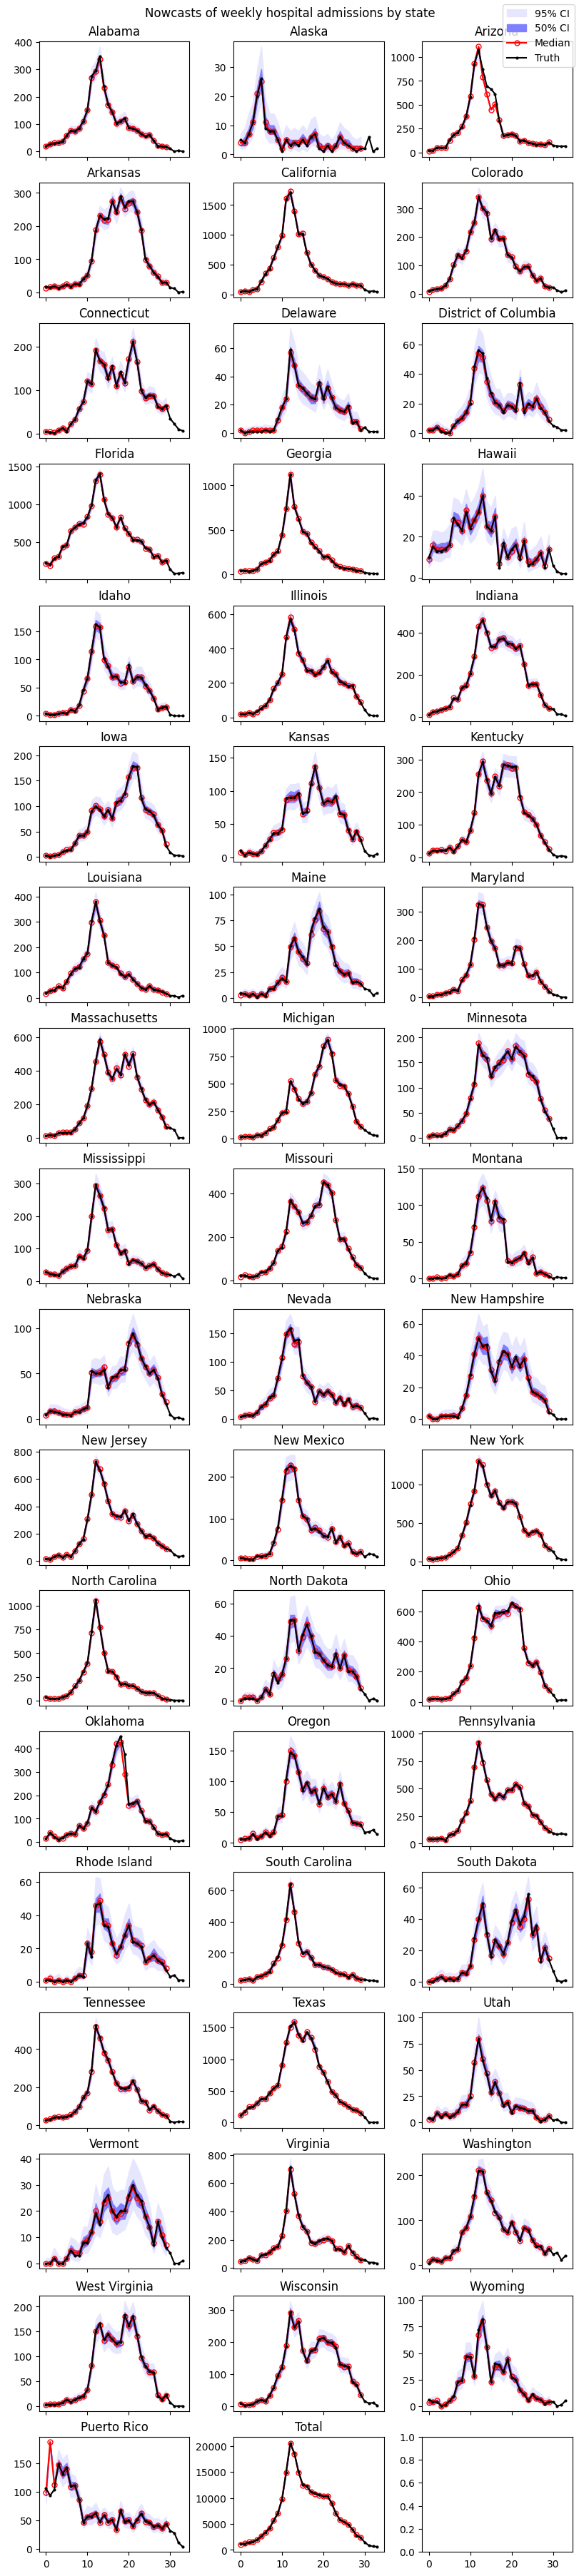

In [7]:
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))
n_weeks_ahead = 0

# The index of the "total" node, which is not an actual node in the model.
total_node = my_rume.scope.nodes

LOWER_95_INDEX = 1
UPPER_95_INDEX = -2
LOWER_50_INDEX = 6
UPPER_50_INDEX = -7
MEDIAN_INDEX = 11

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes + 1):  # Extra plot for the "total" nowcast.
    if node == total_node:
        quantiles_values = forecast_total_quantiles[:, 0, :]
    else:
        quantiles_values = forecast_quantiles[:, 0, :, node]

    t = np.arange(quantiles_values.shape[0])
    axs[node].fill_between(
        t,
        quantiles_values[..., LOWER_95_INDEX],
        quantiles_values[..., UPPER_95_INDEX],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[..., LOWER_50_INDEX],
        quantiles_values[..., UPPER_50_INDEX],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[..., MEDIAN_INDEX],
        color="red",
        marker="o",
        markersize=5,
        fillstyle="none",
    )

    if node == total_node:
        truth = real_data.sum(axis=1)
    else:
        truth = real_data[:, node]

    t = np.arange(truth.shape[0])
    axs[node].plot(t, truth, color="k", linestyle="-", marker="o", markersize=2)

    if node == total_node:
        axs[node].set_title("Total")
    else:
        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])
fig.legend(["95% CI", "50% CI", "Median", "Truth"])
plt.suptitle("Nowcasts of weekly hospital admissions by state")
plt.show()

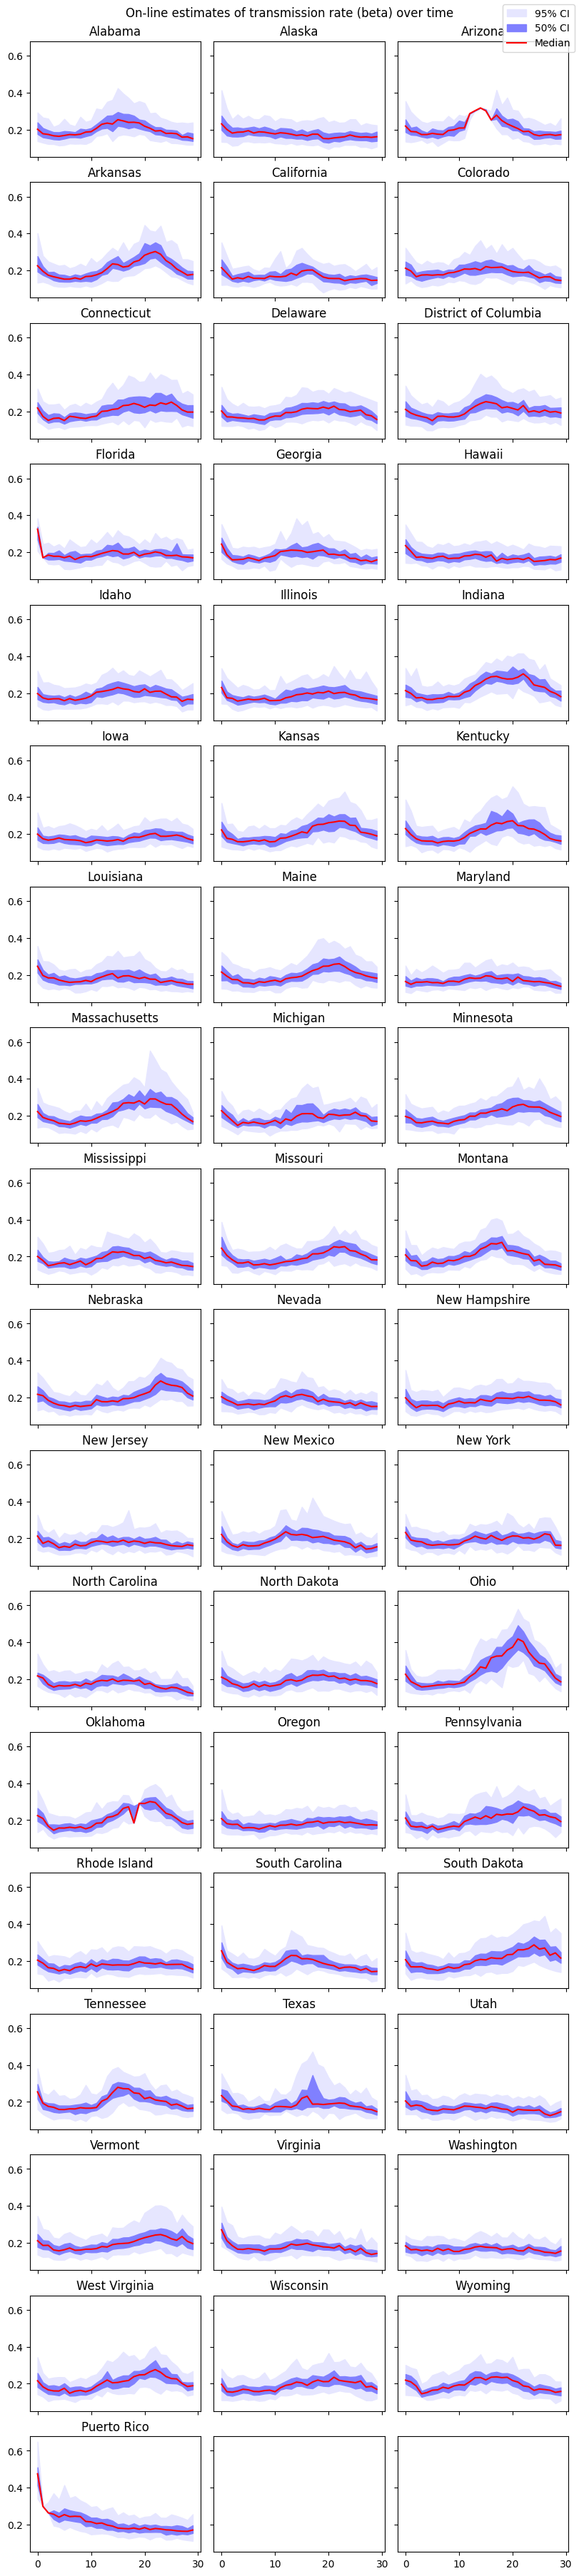

In [8]:
ncols = 3
nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_layout_engine("compressed")
fig.set_figwidth(8)
fig.set_figheight(8 * nrows / 4)
axs = np.ravel(np.array(axs))
for node in range(my_rume.scope.nodes):
    quantiles_values = np.quantile(
        np.exp(estimated_params[NamePattern.of("log_beta")][:, :, node]),
        [0.025, 0.25, 0.50, 0.75, 0.975],
        axis=1,
    )

    t = np.arange(quantiles_values.shape[1])
    axs[node].fill_between(
        t,
        quantiles_values[0, ...],
        quantiles_values[4, ...],
        color=[0.9, 0.9, 1],
    )
    axs[node].fill_between(
        t,
        quantiles_values[1, ...],
        quantiles_values[3, ...],
        color=[0.5, 0.5, 1],
    )
    axs[node].plot(
        t,
        quantiles_values[2, ...],
        color="red",
    )

    axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

fig.legend(["95% CI", "50% CI", "Median"])

plt.suptitle("On-line estimates of transmission rate (beta) over time")
plt.show()

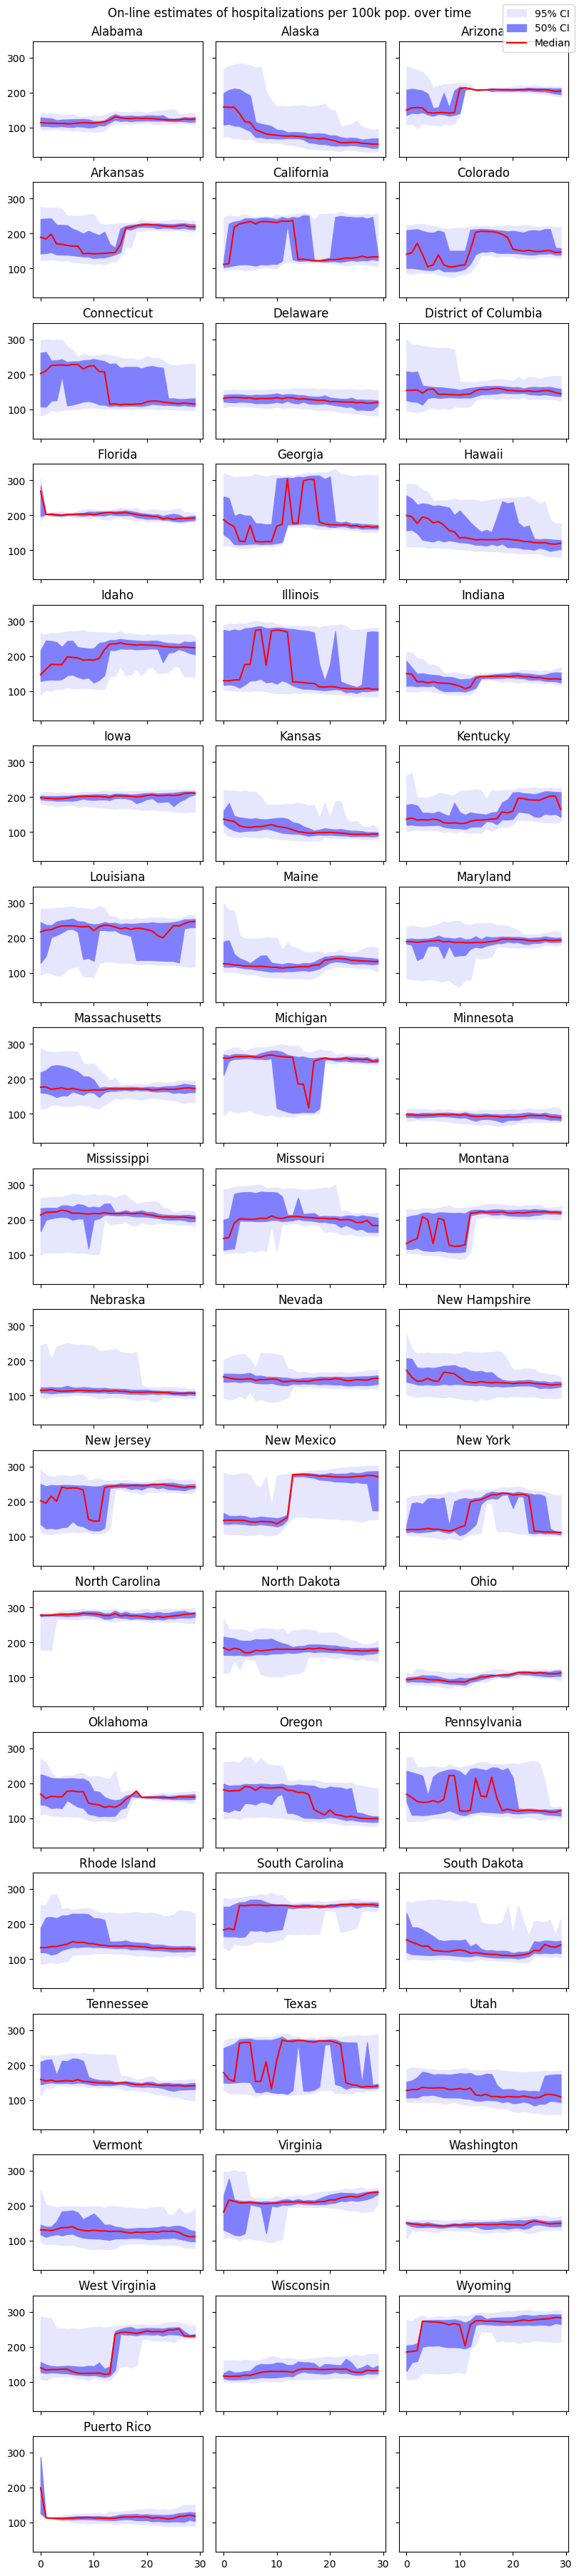

In [9]:
if "hospitalization_prob" in my_unknown_params.keys():
    ncols = 3
    nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    fig.set_layout_engine("compressed")
    fig.set_figwidth(8)
    fig.set_figheight(8 * nrows / 4)
    axs = np.ravel(np.array(axs))
    for node in range(my_rume.scope.nodes):
        quantiles_values = np.quantile(
            100_000
            * estimated_params[NamePattern.of("hospitalization_prob")][:, :, node],
            [0.025, 0.25, 0.50, 0.75, 0.975],
            axis=1,
        )

        t = np.arange(quantiles_values.shape[1])
        axs[node].fill_between(
            t,
            quantiles_values[0, ...],
            quantiles_values[4, ...],
            color=[0.9, 0.9, 1],
        )
        axs[node].fill_between(
            t,
            quantiles_values[1, ...],
            quantiles_values[3, ...],
            color=[0.5, 0.5, 1],
        )
        axs[node].plot(
            t,
            quantiles_values[2, ...],
            color="red",
        )

        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

    fig.legend(["95% CI", "50% CI", "Median"])

    plt.suptitle("On-line estimates of hospitalizations per 100k pop. over time")
    plt.show()

In [10]:
if "gamma" in my_unknown_params.keys():
    ncols = 3
    nrows = int(np.ceil((my_rume.scope.nodes + 1) / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    fig.set_layout_engine("compressed")
    fig.set_figwidth(8)
    fig.set_figheight(8 * nrows / 4)
    axs = np.ravel(np.array(axs))
    for node in range(my_rume.scope.nodes):
        quantiles_values = np.quantile(
            1 / estimated_params[NamePattern.of("gamma")][:, :, node],
            [0.025, 0.25, 0.50, 0.75, 0.975],
            axis=1,
        )

        t = np.arange(quantiles_values.shape[1])
        axs[node].fill_between(
            t,
            quantiles_values[0, ...],
            quantiles_values[4, ...],
            color=[0.9, 0.9, 1],
        )
        axs[node].fill_between(
            t,
            quantiles_values[1, ...],
            quantiles_values[3, ...],
            color=[0.5, 0.5, 1],
        )
        axs[node].plot(
            t,
            quantiles_values[2, ...],
            color="red",
        )

        axs[node].set_title(my_rume.scope.get_info()["NAME"][node])

    fig.legend(["95% CI", "50% CI", "Median"])

    plt.suptitle("On-line estimates of duration of infection over time")
    plt.show()

In [11]:
if save_csv:
    for forecast_index in range(len(reference_dates)):
        values = np.concatenate(
            [
                forecast_quantiles[forecast_index, ...],
                forecast_total_quantiles[forecast_index, ..., np.newaxis],
            ],
            axis=2,
        )

        reference_date = str(reference_dates[forecast_index])
        targets = ["wk inc flu hosp"]
        horizons = [-1, 0, 1, 2, 3]
        target_end_dates = [
            str(reference_dates[forecast_index] + np.timedelta64(7 * horizon))
            for horizon in horizons
        ]
        locations = list(my_scope.node_ids) + ["US"]
        output_types = ["quantile"]
        output_type_ids = list(save_quantiles)

        data = {
            "reference_date": np.broadcast_to(
                np.reshape(np.array([reference_date]), (1, 1, 1)), values.shape
            ).flatten(),
            "target": np.broadcast_to(
                np.reshape(np.array(targets), (1, 1, 1)), values.shape
            ).flatten(),
            "horizon": np.broadcast_to(
                np.reshape(np.array(horizons), (-1, 1, 1)), values.shape
            ).flatten(),
            "target_end_date": np.broadcast_to(
                np.reshape(np.array(target_end_dates), (-1, 1, 1)), values.shape
            ).flatten(),
            "location": np.broadcast_to(
                np.reshape(np.array(locations), (1, 1, -1)), values.shape
            ).flatten(),
            "output_type": np.broadcast_to(
                np.reshape(np.array(output_types), (1, 1, 1)), values.shape
            ).flatten(),
            "output_type_id": np.broadcast_to(
                np.reshape(np.array(output_type_ids), (1, -1, 1)), values.shape
            ).flatten(),
            "value": values.flatten(),
        }

        sorted = pd.DataFrame(data).sort_values(
            by=["horizon", "location", "output_type_id"]
        )
        sorted.to_csv(f"./output/{reference_date}.csv", index=False)

In [12]:
loaded_data = pd.read_csv("./output/2023-10-14.csv").pivot_table(
    values="value", index=["horizon", "output_type_id", "location"]
)
loaded_data = loaded_data.to_numpy().reshape(loaded_data.index.levshape)[..., :-1]

In [13]:
loaded_data.shape

(5, 23, 52)

In [14]:
A = pd.read_csv("./output/2023-10-14.csv").pivot_table(
    values="value", index=["horizon", "output_type_id", "location"]
)

In [15]:
A.index.to_numpy()

array([(-1, 0.01, '01'), (-1, 0.01, '02'), (-1, 0.01, '04'), ...,
       (3, 0.99, '56'), (3, 0.99, '72'), (3, 0.99, 'US')], dtype=object)

In [16]:
loaded_data.shape

(5, 23, 52)